In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, LSTM, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [12]:
def load_stock_data(filepath):
    df = pd.read_csv(filepath)
    df['Date'] = pd.to_datetime(df['Date'])
    df.set_index('Date', inplace=True)
    return df

In [13]:
def create_sequences(data, target, seq_length=10):
    X_seq, y_seq = [],[]
    for i in range(len(data) - seq_length):
        X_seq.append(data[i:i+seq_length])
        y_seq.append(target[i+seq_length])
    return np.array(X_seq), np.array(y_seq)

In [14]:
def train_xgboost_lstm(stock_name, seq_length=10):
    """Trains XGBoost and LSTM for a given stock."""
    
    print(f"\nTraining XGBoost + Bidirectional LSTM for {stock_name.upper()}\n")

    # Load Data
    file_path = f"../data/{stock_name}_stock_features_selected.csv"
    df = load_stock_data(file_path)

    # Target Variable: Close Price
    y = df[['Close']].values  # Using Close Price as target
    X = df.drop(columns=['Close'])  # Features exclude Close

    # Split Data (80% Train, 20% Test)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Scale Data
    scaler_X = MinMaxScaler()
    scaler_y = MinMaxScaler()

    X_train_scaled = scaler_X.fit_transform(X_train)
    X_test_scaled = scaler_X.transform(X_test)

    y_train_scaled = scaler_y.fit_transform(y_train)
    y_test_scaled = scaler_y.transform(y_test)

    # ---------------------------
    # Train XGBoost Model
    # ---------------------------
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
    xgb_model.fit(X_train_scaled, y_train_scaled.ravel())

    # XGBoost Predictions
    y_pred_xgb_train = xgb_model.predict(X_train_scaled).reshape(-1, 1)
    y_pred_xgb_test = xgb_model.predict(X_test_scaled).reshape(-1, 1)

    # ---------------------------
    # Prepare Data for LSTM
    # ---------------------------
    train_lstm_input = np.hstack((X_train_scaled, y_pred_xgb_train))
    test_lstm_input = np.hstack((X_test_scaled, y_pred_xgb_test))

    X_train_lstm, y_train_lstm = create_sequences(train_lstm_input, y_train_scaled, seq_length)
    X_test_lstm, y_test_lstm = create_sequences(test_lstm_input, y_test_scaled, seq_length)

    # Reshape for LSTM (samples, timesteps, features)
    X_train_lstm = X_train_lstm.reshape(X_train_lstm.shape[0], seq_length, -1)
    X_test_lstm = X_test_lstm.reshape(X_test_lstm.shape[0], seq_length, -1)

    model = Sequential([
        Bidirectional(LSTM(64, return_sequences=True, input_shape=(seq_length, X_train_lstm.shape[2]))),
        Dropout(0.1),
        Bidirectional(LSTM(50,return_sequences=False)),
        Dropout(0.1),
        Dense(units=25),
        Dense(units=1)
    ])

    model.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

    # Callbacks for Performance Optimization
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5)
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # Train LSTM
    history = model.fit(X_train_lstm, y_train_lstm, 
                        epochs=50, batch_size=32, 
                        validation_data=(X_test_lstm, y_test_lstm), 
                        verbose=1, callbacks=[reduce_lr, early_stopping])

    y_pred_lstm = model.predict(X_test_lstm)
    y_pred_lstm = scaler_y.inverse_transform(y_pred_lstm)

    y_test_actual = scaler_y.inverse_transform(y_test_lstm.reshape(-1, 1))

    mse = tf.keras.losses.MeanSquaredError()(y_test_actual, y_pred_lstm).numpy()
    r2 = 1 - (np.sum((y_test_actual - y_pred_lstm)**2)/np.sum((y_test_actual - np.mean(y_test_actual))**2))

    print(f"MSE: {mse:.5f}, R2: {r2:.5f}")

    # Plot Results
    plt.figure(figsize=(12, 6))
    plt.plot(y_test_actual, label="Actual Close Price", color='blue')
    plt.plot(scaler_y.inverse_transform(y_pred_xgb_test[seq_length:]), label="XGBoost Prediction", color='orange')
    plt.plot(y_pred_lstm, label="XGBoost + LSTM Prediction", color='red')
    plt.legend()
    plt.title(f"{stock_name.upper()} Stock Price Prediction: XGBoost vs XGBoost+LSTM")
    plt.show()

    return model, history


Training XGBoost + Bidirectional LSTM for NVIDIA

Epoch 1/50
159/159 [==============================] - 11s 26ms/step - loss: 0.0027 - val_loss: 51.9388 - lr: 0.0010
Epoch 2/50
159/159 [==============================] - 3s 20ms/step - loss: 5.4942e-04 - val_loss: 51.4949 - lr: 0.0010
Epoch 3/50
159/159 [==============================] - 3s 18ms/step - loss: 4.8688e-04 - val_loss: 49.6795 - lr: 0.0010
Epoch 4/50
159/159 [==============================] - 3s 19ms/step - loss: 4.4971e-04 - val_loss: 50.4931 - lr: 0.0010
Epoch 5/50
159/159 [==============================] - 3s 18ms/step - loss: 3.3807e-04 - val_loss: 50.5353 - lr: 0.0010
Epoch 6/50
159/159 [==============================] - 3s 18ms/step - loss: 4.9227e-04 - val_loss: 49.6330 - lr: 0.0010
Epoch 7/50
159/159 [==============================] - 3s 18ms/step - loss: 2.7189e-04 - val_loss: 50.7278 - lr: 0.0010
Epoch 8/50
159/159 [==============================] - 3s 18ms/step - loss: 3.6219e-04 - val_loss: 49.5119 - lr: 0.0010


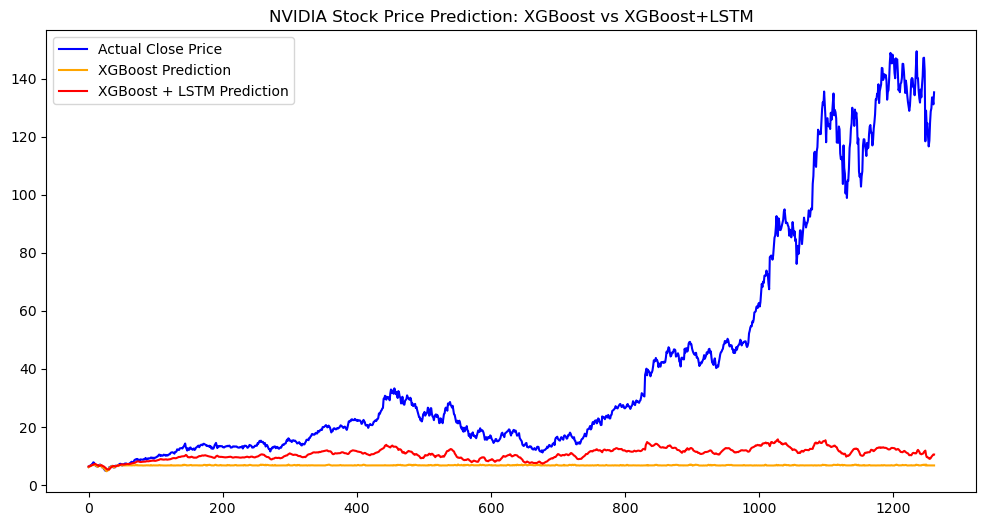

(<keras.engine.sequential.Sequential at 0x157b29de730>,
 <keras.callbacks.History at 0x157b29d6fd0>)

In [15]:
train_xgboost_lstm("nvidia")


Training XGBoost + Bidirectional LSTM for APPLE

Epoch 1/50
274/274 [==============================] - 12s 23ms/step - loss: 0.0014 - val_loss: 8.5972 - lr: 0.0010
Epoch 2/50
274/274 [==============================] - 5s 19ms/step - loss: 4.2538e-04 - val_loss: 8.2570 - lr: 0.0010
Epoch 3/50
274/274 [==============================] - 5s 19ms/step - loss: 3.9250e-04 - val_loss: 7.6164 - lr: 0.0010
Epoch 4/50
274/274 [==============================] - 5s 19ms/step - loss: 3.1824e-04 - val_loss: 7.9631 - lr: 0.0010
Epoch 5/50
274/274 [==============================] - 5s 19ms/step - loss: 2.8166e-04 - val_loss: 7.4897 - lr: 0.0010
Epoch 6/50
274/274 [==============================] - 5s 19ms/step - loss: 2.5010e-04 - val_loss: 7.0742 - lr: 0.0010
Epoch 7/50
274/274 [==============================] - 5s 19ms/step - loss: 2.4285e-04 - val_loss: 7.4656 - lr: 0.0010
Epoch 8/50
274/274 [==============================] - 5s 19ms/step - loss: 2.1466e-04 - val_loss: 7.5178 - lr: 0.0010
Epoch 9/5

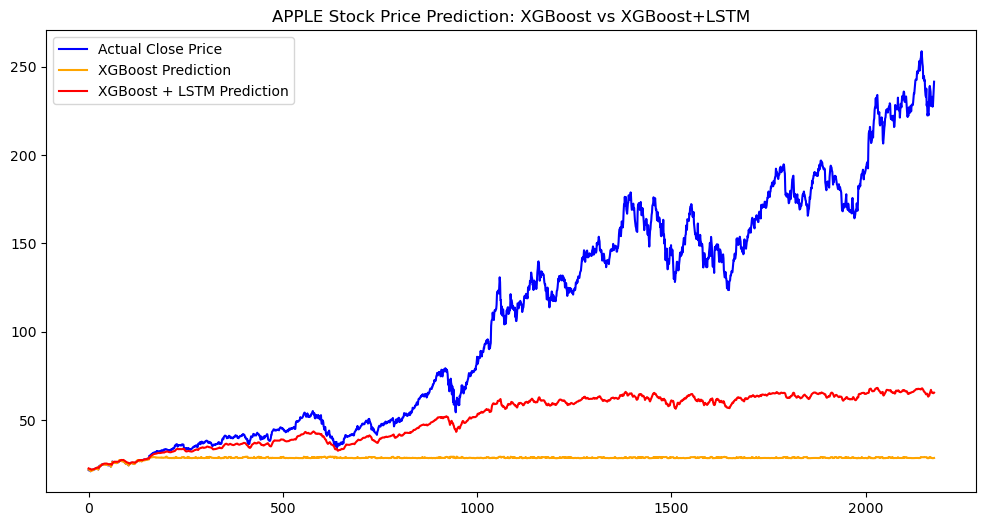

(<keras.engine.sequential.Sequential at 0x157325a6a00>,
 <keras.callbacks.History at 0x157325cd8e0>)

In [16]:
train_xgboost_lstm("apple")


Training XGBoost + Bidirectional LSTM for MICROSOFT

Epoch 1/50
240/240 [==============================] - 11s 23ms/step - loss: 0.0013 - val_loss: 5.9521 - lr: 0.0010
Epoch 2/50
240/240 [==============================] - 4s 18ms/step - loss: 3.7479e-04 - val_loss: 5.6859 - lr: 0.0010
Epoch 3/50
240/240 [==============================] - 4s 18ms/step - loss: 3.3650e-04 - val_loss: 5.6112 - lr: 0.0010
Epoch 4/50
240/240 [==============================] - 4s 18ms/step - loss: 2.5871e-04 - val_loss: 5.8433 - lr: 0.0010
Epoch 5/50
240/240 [==============================] - 4s 18ms/step - loss: 2.4293e-04 - val_loss: 5.0923 - lr: 0.0010
Epoch 6/50
240/240 [==============================] - 4s 18ms/step - loss: 2.5067e-04 - val_loss: 5.1862 - lr: 0.0010
Epoch 7/50
240/240 [==============================] - 4s 18ms/step - loss: 1.9276e-04 - val_loss: 5.1097 - lr: 0.0010
Epoch 8/50
240/240 [==============================] - 4s 18ms/step - loss: 1.6345e-04 - val_loss: 5.1769 - lr: 0.0010
Epoch

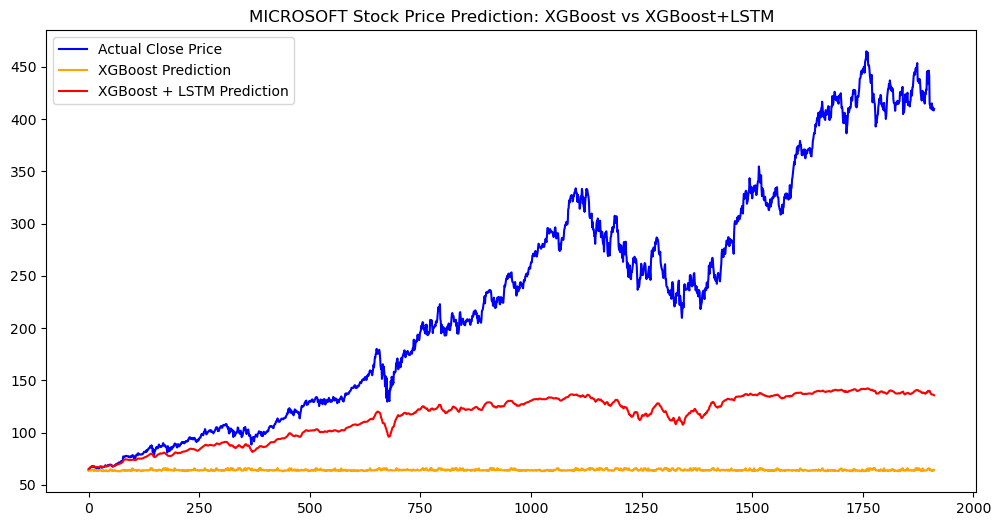

(<keras.engine.sequential.Sequential at 0x1562ffdfe20>,
 <keras.callbacks.History at 0x157792f6e50>)

In [17]:
train_xgboost_lstm("microsoft")

1. Key Observations from the Plots
- XGBoost predictions (yellow line) are consistently lower than actual stock prices (blue line).
- XGBoost + LSTM predictions (red line) show slight improvement over XGBoost alone, but still significantly underpredict stock movements.
- The models for Apple and Microsoft perform better than NVIDIA, though the errors are still significant.

2. Evaluation Metrics Comparison

NVIDIA

- MSE: 2486.93 (compared to CNN + LSTM: 2280.17)
- R²: -0.5202 (worse than CNN + LSTM: -0.3938)
- XGBoost + LSTM actually performs worse for NVIDIA than CNN + LSTM. The predictions are still failing to capture upward trends.

APPLE

- MSE: 6012.27 (CNN + LSTM: 6116.31)
- R²: -0.4098 (CNN + LSTM: -0.4342)
- Apple shows minor improvement compared to CNN + LSTM. The XGBoost + LSTM hybrid model is slightly better, but it’s still far from acceptable.

MICROSOFT

- MSE: 21790.31 (CNN + LSTM: 10199.41)
- R²: -0.7065 (CNN + LSTM: 0.2012)
- Microsoft performed significantly worse than before. The model is struggling with high volatility.

3. Issues with the Model
- Predictions are consistently lower than actual values
- The model is likely biased towards the mean stock price and fails to capture volatility.

4. Poor Generalization
- R² values are negative, meaning the model is performing worse than a naive mean predictor.
- Overfitting to training data? The loss is low in training but high in validation.
- XGBoost + LSTM Hybrid May Not Be Working Effectively
- XGBoost is great at tabular data but may not be capturing sequential dependencies well.
- The LSTM layer might not be leveraging enough time series patterns.